# Crucible 3: h_mean Persistence and Cloud Liftoff

**Primary questions:**
1. Does h_mean autocorrelation stay at ~0.95 over 500 steps, or decay?
2. When does the origin exit each token cloud's bounding hypersphere?

**Context:** From `h_mean_autocorrelation.ipynb` (10 steps), we found h_mean[t] maintains high directional alignment (cosine ≈ 0.95). But is this a persistent feature or just early-training artifact?

**Bounding sphere question:** Treat each population (live, dead) as a spherical cow. At what timestep does the origin of coordinates fall outside the bounding hypersphere (centered at centroid, radius = max distance to any token)?

## Setup

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
DATA_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-3' / 'crucible_3_trajectory.safetensors'

# Style
plt.rcParams['figure.dpi'] = 200
STEELBLUE = '#4682B4'

print(f"Loading data from {DATA_PATH}")

Loading data from /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-3/crucible_3_trajectory.safetensors


## Load Data

In [4]:
data = load_file(str(DATA_PATH))

# Convert W from uint16 bitpattern to bfloat16, then float32
W = data['W'].view(torch.bfloat16).float()  # (501, 10000, 64)
h_mean = data['h_mean'].float()              # (500, 64)
loss = data['loss'].float()                  # (501,)
dead_mask = data['dead_mask'].bool()
live_mask = ~dead_mask

n_steps = W.shape[0] - 1  # 500 steps (501 snapshots including t=0)
n_tokens = W.shape[1]
n_dims = W.shape[2]
n_dead = dead_mask.sum().item()
n_live = live_mask.sum().item()

print(f"Loaded Crucible 3 data:")
print(f"  Steps: {n_steps} (snapshots: {W.shape[0]})")
print(f"  Tokens: {n_tokens} ({n_live} live, {n_dead} dead)")
print(f"  Dimensions: {n_dims}")
print(f"  h_mean shape: {h_mean.shape}")

Loaded Crucible 3 data:
  Steps: 500 (snapshots: 501)
  Tokens: 10000 (6301 live, 3699 dead)
  Dimensions: 64
  h_mean shape: torch.Size([500, 64])


---

# 1. h_mean Autocorrelation Over 500 Steps

Does h_mean maintain consistent direction throughout training?

In [5]:
# Compute cosine similarity between consecutive h_mean vectors
def cosine_similarity(a, b):
    """Cosine similarity between two vectors."""
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

h_autocorr = torch.zeros(n_steps - 1)
for t in range(n_steps - 1):
    h_autocorr[t] = cosine_similarity(h_mean[t], h_mean[t+1])

print("h_mean autocorrelation (consecutive steps):")
print(f"  Mean: {h_autocorr.mean().item():.6f}")
print(f"  Std: {h_autocorr.std().item():.6f}")
print(f"  Min: {h_autocorr.min().item():.6f}")
print(f"  Max: {h_autocorr.max().item():.6f}")
print(f"  Median: {h_autocorr.median().item():.6f}")

h_mean autocorrelation (consecutive steps):
  Mean: 0.997557
  Std: 0.016628
  Min: 0.631758
  Max: 0.999984
  Median: 0.998699


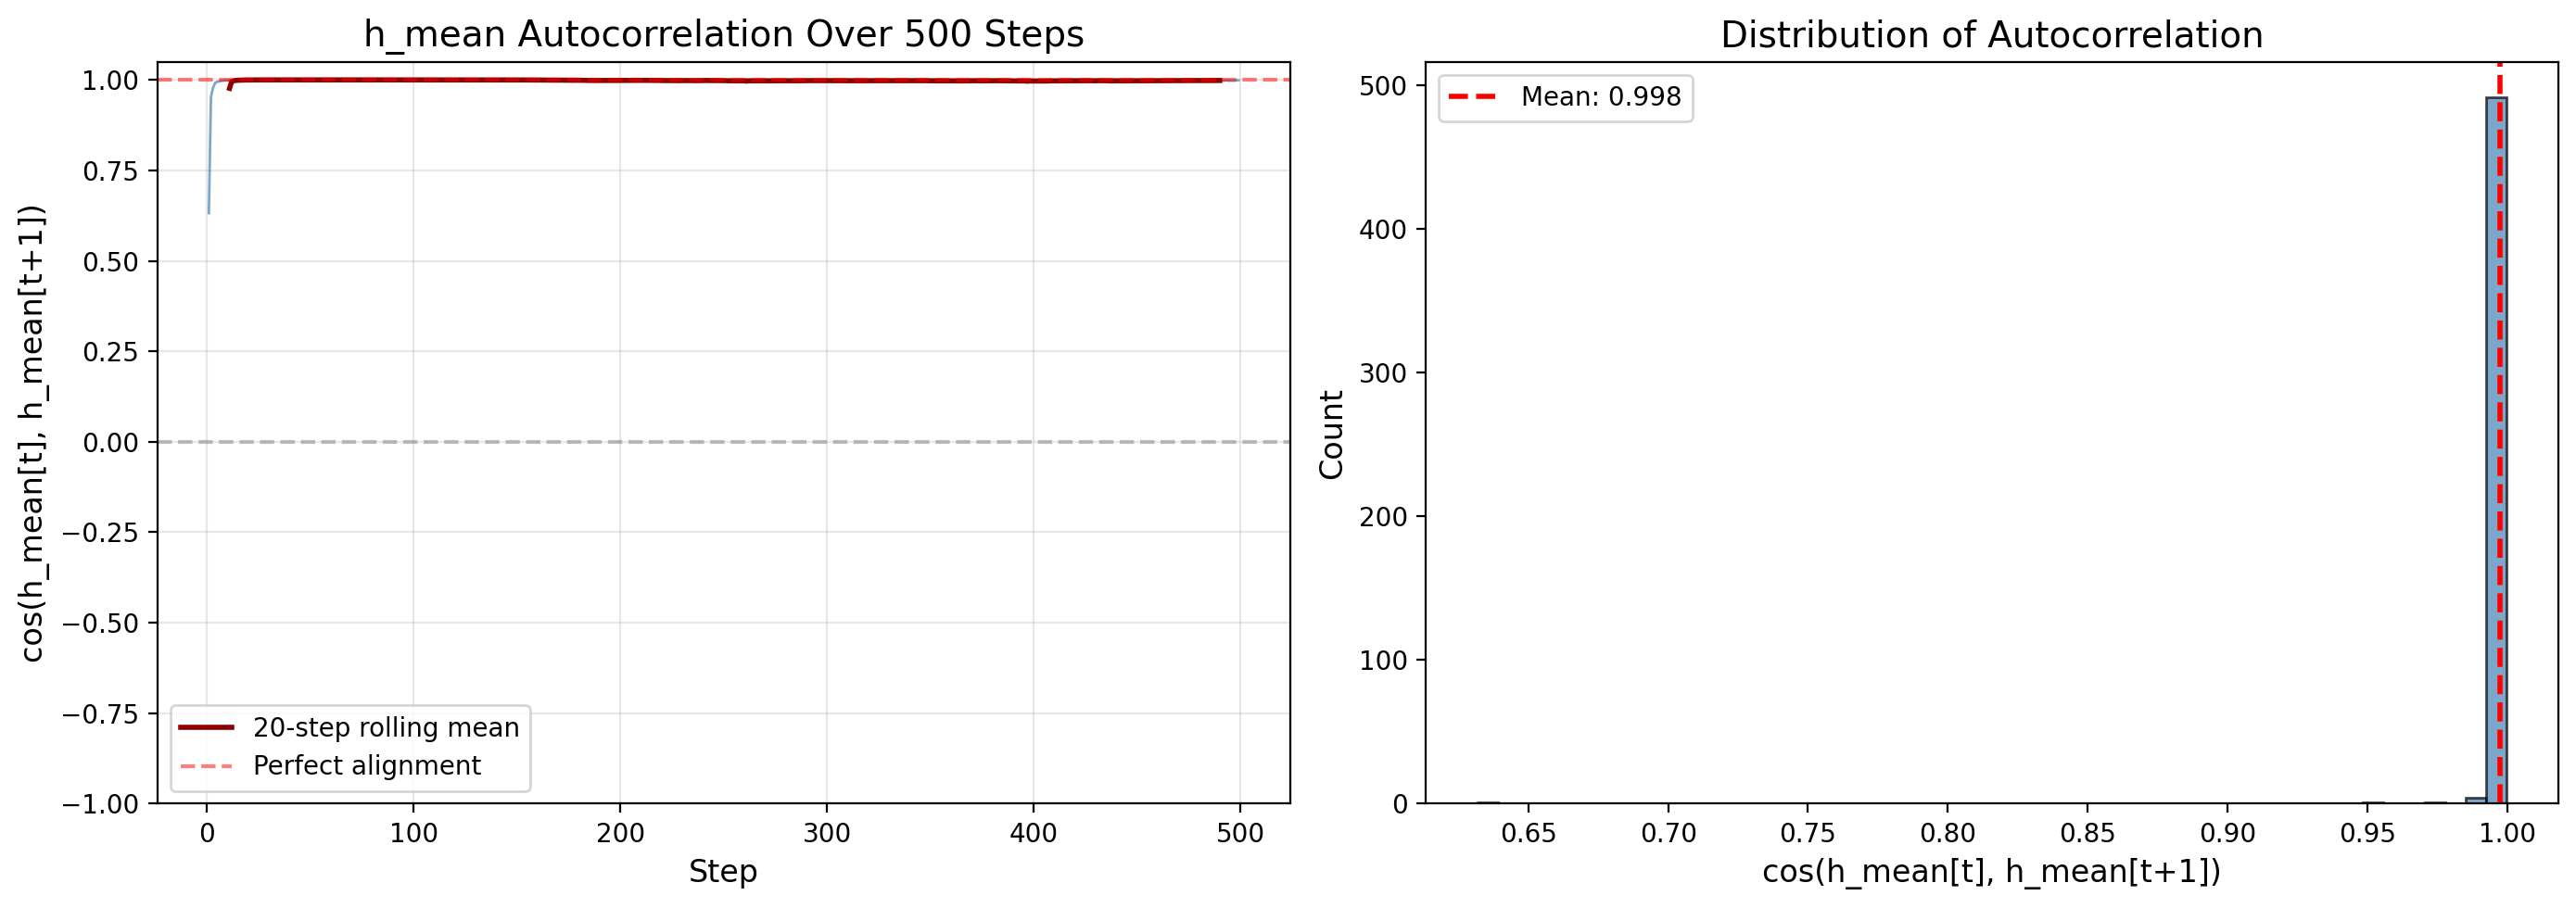

In [6]:
# Plot h_mean autocorrelation over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time series
ax = axes[0]
ax.plot(range(1, n_steps), h_autocorr.detach().numpy(), color=STEELBLUE, linewidth=1, alpha=0.7)

# Rolling mean for trend
window = 20
rolling_mean = np.convolve(h_autocorr.detach().numpy(), np.ones(window)/window, mode='valid')
ax.plot(range(1 + window//2, n_steps - window//2 + 1), rolling_mean, color='darkred', linewidth=2, label=f'{window}-step rolling mean')

ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect alignment')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('cos(h_mean[t], h_mean[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation Over 500 Steps', fontsize=14)
ax.set_ylim(-1, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

# Right: Histogram
ax = axes[1]
ax.hist(h_autocorr.detach().numpy(), bins=50, color=STEELBLUE, alpha=0.7, edgecolor='black')
ax.axvline(h_autocorr.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {h_autocorr.mean().item():.3f}')
ax.set_xlabel('cos(h_mean[t], h_mean[t+1])', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Autocorrelation', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## Zoomed View: Natural Range

Same data, but y-axis limited to the natural range to see fine structure.

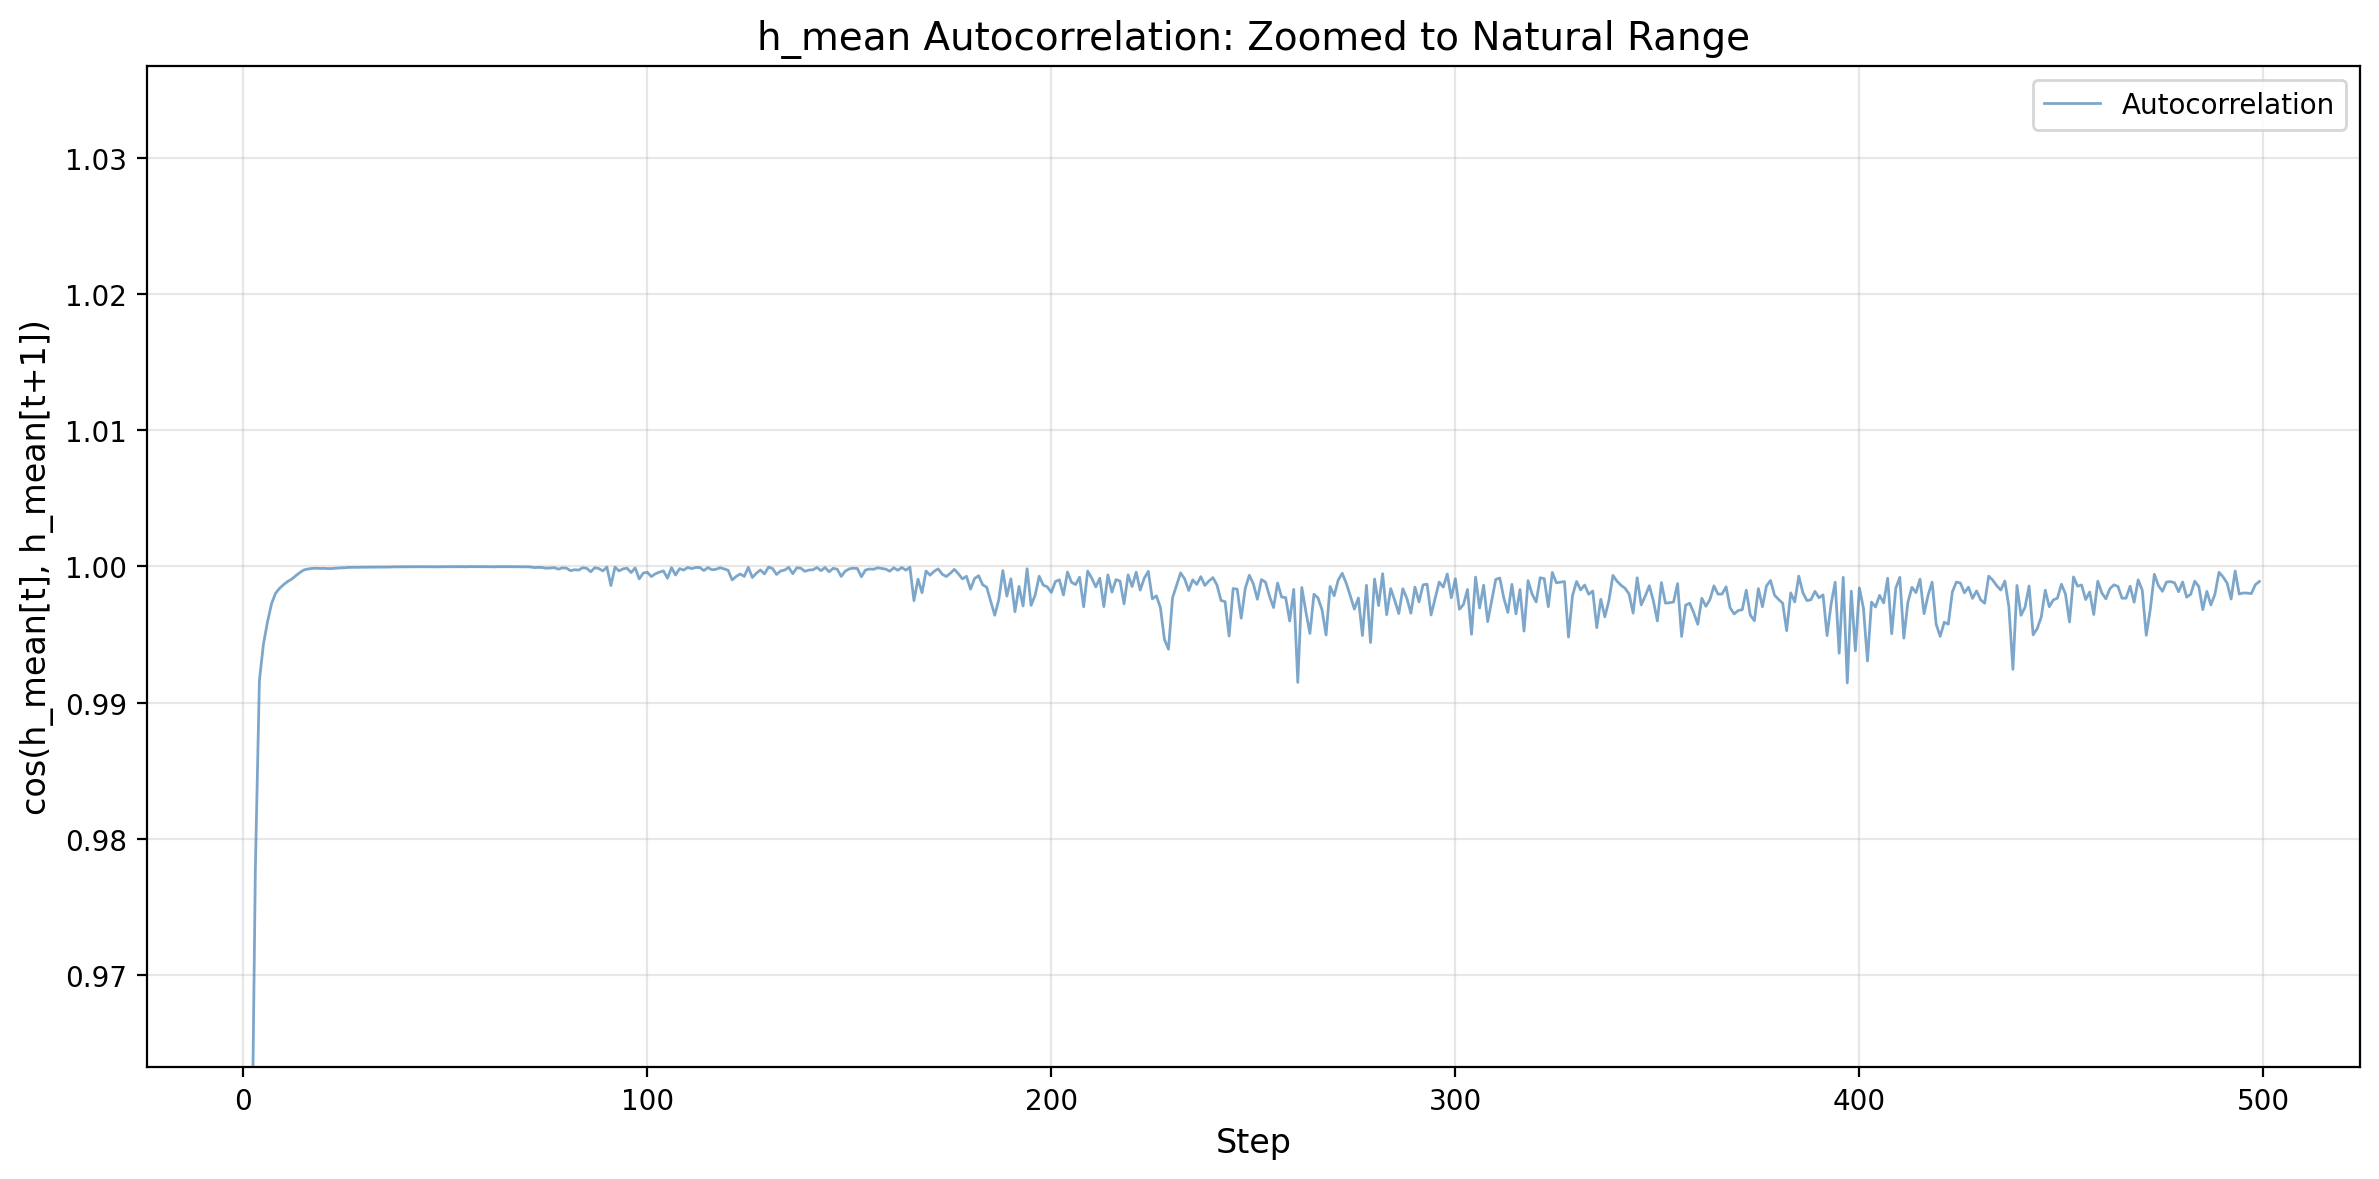

\nNatural range: [0.6318, 1.0000]


In [83]:
# Zoomed plot: natural y-axis range
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, n_steps), h_autocorr.detach().numpy(), color=STEELBLUE, linewidth=1, alpha=0.7, label='Autocorrelation')

# Set y-axis to natural range (with small padding)
y_min = h_autocorr.min().item()
y_max = h_autocorr.max().item()
y_padding = (y_max - y_min) * 0.1
ax.set_ylim(1 - y_padding, y_max + y_padding)

ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('cos(h_mean[t], h_mean[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation: Zoomed to Natural Range', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\\nNatural range: [{y_min:.4f}, {y_max:.4f}]")

## h_mean Autocorrelation in Bins

Break the 500 steps into bins to see if autocorrelation changes over training.

In [84]:
# Compute autocorrelation in bins: [0-99], [100-199], [200-299], [300-399], [400-499]
bin_size = 100
n_bins = n_steps // bin_size

bin_means = []
bin_stds = []
bin_labels = []

for i in range(n_bins):
    start = i * bin_size
    end = (i + 1) * bin_size
    
    # Autocorr indices are 0-based, so bin [0-99] uses autocorr[0:99]
    bin_data = h_autocorr[start:min(end-1, len(h_autocorr))]
    
    bin_means.append(bin_data.mean().item())
    bin_stds.append(bin_data.std().item())
    bin_labels.append(f'{start}-{end-1}')

print("h_mean autocorrelation by training phase:")
for i, label in enumerate(bin_labels):
    print(f"  Steps {label}: mean = {bin_means[i]:.4f}, std = {bin_stds[i]:.4f}")

h_mean autocorrelation by training phase:
  Steps 0-99: mean = 0.9952, std = 0.0373
  Steps 100-199: mean = 0.9993, std = 0.0008
  Steps 200-299: mean = 0.9979, std = 0.0014
  Steps 300-399: mean = 0.9975, std = 0.0014
  Steps 400-499: mean = 0.9978, std = 0.0013


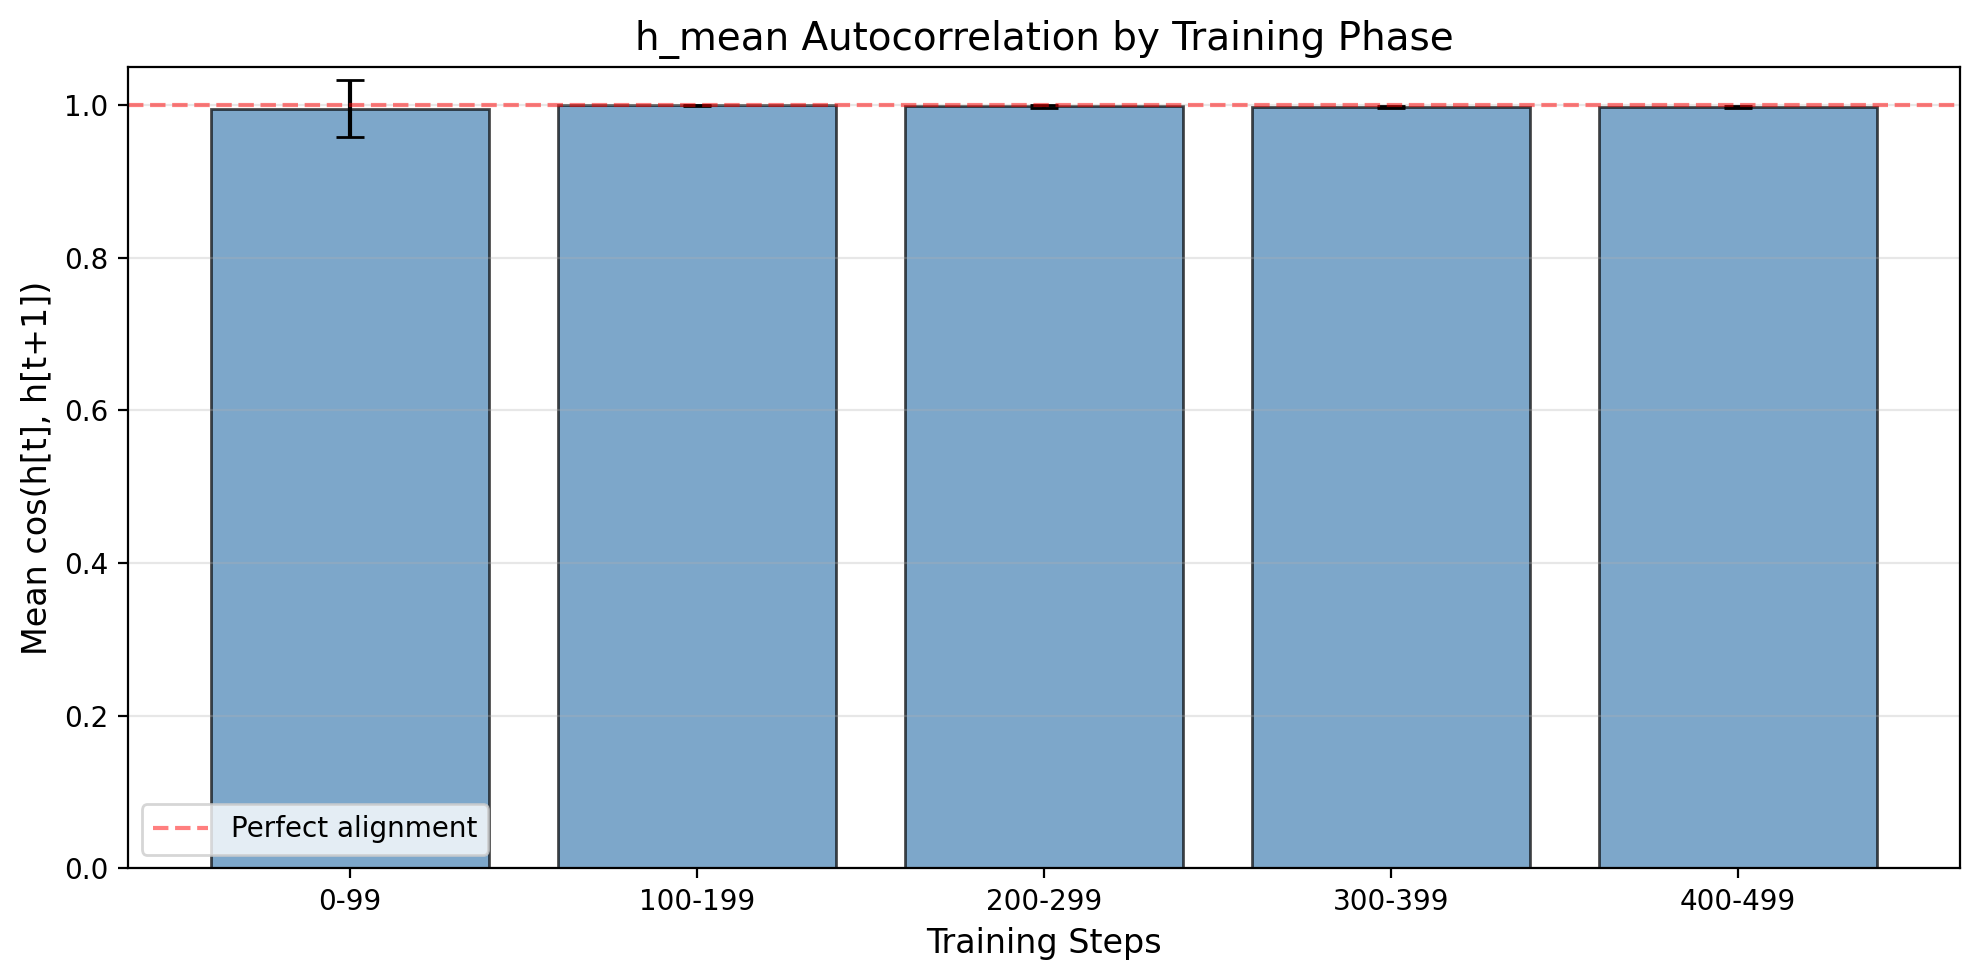

In [85]:
# Plot autocorrelation trend by bin
fig, ax = plt.subplots(figsize=(10, 5))

x_pos = np.arange(len(bin_labels))
ax.bar(x_pos, bin_means, yerr=bin_stds, color=STEELBLUE, alpha=0.7, capsize=5, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(bin_labels)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect alignment')
ax.set_xlabel('Training Steps', fontsize=12)
ax.set_ylabel('Mean cos(h[t], h[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation by Training Phase', fontsize=14)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

---

# 2. When Does the Origin Exit Each Cloud?

**Method:** For each population (live, dead):
1. Compute centroid[t]
2. Compute bounding radius[t] = max distance from centroid to any token
3. Find first timestep where ||centroid[t]|| > radius[t]

This means the origin is outside the bounding hypersphere—the cloud has "lifted off."

In [86]:
# Separate live and dead tokens
W_live = W[:, live_mask, :]  # (501, n_live, 64)
W_dead = W[:, dead_mask, :]  # (501, n_dead, 64)

print(f"Live tokens: {W_live.shape}")
print(f"Dead tokens: {W_dead.shape}")

Live tokens: torch.Size([501, 6301, 64])
Dead tokens: torch.Size([501, 3699, 64])


In [87]:
# Compute centroids and bounding radii for each timestep
centroid_live = W_live.mean(dim=1)  # (501, 64)
centroid_dead = W_dead.mean(dim=1)  # (501, 64)

# Bounding radius: max distance from centroid to any token in that population
def compute_bounding_radius(W_pop, centroid):
    """Compute bounding radius for a population at each timestep."""
    # W_pop: (n_steps+1, n_tokens_in_pop, n_dims)
    # centroid: (n_steps+1, n_dims)
    distances = torch.norm(W_pop - centroid.unsqueeze(1), dim=2)  # (n_steps+1, n_tokens_in_pop)
    radius = distances.max(dim=1)[0]  # (n_steps+1,)
    return radius

radius_live = compute_bounding_radius(W_live, centroid_live)
radius_dead = compute_bounding_radius(W_dead, centroid_dead)

print(f"\nBounding radii computed:")
print(f"  Live radius at t=0: {radius_live[0].item():.6f}")
print(f"  Live radius at t=500: {radius_live[-1].item():.6f}")
print(f"  Dead radius at t=0: {radius_dead[0].item():.6f}")
print(f"  Dead radius at t=500: {radius_dead[-1].item():.6f}")


Bounding radii computed:
  Live radius at t=0: 0.211061
  Live radius at t=500: 1.336532
  Dead radius at t=0: 0.213410
  Dead radius at t=500: 0.152761


In [88]:
# Distance from origin to centroid
dist_to_origin_live = torch.norm(centroid_live, dim=1)  # (501,)
dist_to_origin_dead = torch.norm(centroid_dead, dim=1)  # (501,)

print(f"\nCentroid distance from origin:")
print(f"  Live at t=0: {dist_to_origin_live[0].item():.6f}")
print(f"  Live at t=500: {dist_to_origin_live[-1].item():.6f}")
print(f"  Dead at t=0: {dist_to_origin_dead[0].item():.6f}")
print(f"  Dead at t=500: {dist_to_origin_dead[-1].item():.6f}")


Centroid distance from origin:
  Live at t=0: 0.002314
  Live at t=500: 0.216914
  Dead at t=0: 0.002889
  Dead at t=500: 0.635706


In [89]:
# Find liftoff: first timestep where ||centroid|| > radius
def find_liftoff(dist_to_origin, radius):
    """Find first timestep where origin is outside the bounding sphere."""
    outside = dist_to_origin > radius
    if outside.any():
        return outside.nonzero()[0].item()
    else:
        return None

liftoff_live = find_liftoff(dist_to_origin_live, radius_live)
liftoff_dead = find_liftoff(dist_to_origin_dead, radius_dead)

print("\n" + "=" * 60)
print("LIFTOFF ANALYSIS")
print("=" * 60)
if liftoff_live is not None:
    print(f"Live tokens: origin exits bounding sphere at step {liftoff_live}")
else:
    print(f"Live tokens: origin NEVER exits bounding sphere (still inside at t=500)")

if liftoff_dead is not None:
    print(f"Dead tokens: origin exits bounding sphere at step {liftoff_dead}")
else:
    print(f"Dead tokens: origin NEVER exits bounding sphere (still inside at t=500)")
print("=" * 60)


LIFTOFF ANALYSIS
Live tokens: origin NEVER exits bounding sphere (still inside at t=500)
Dead tokens: origin exits bounding sphere at step 31


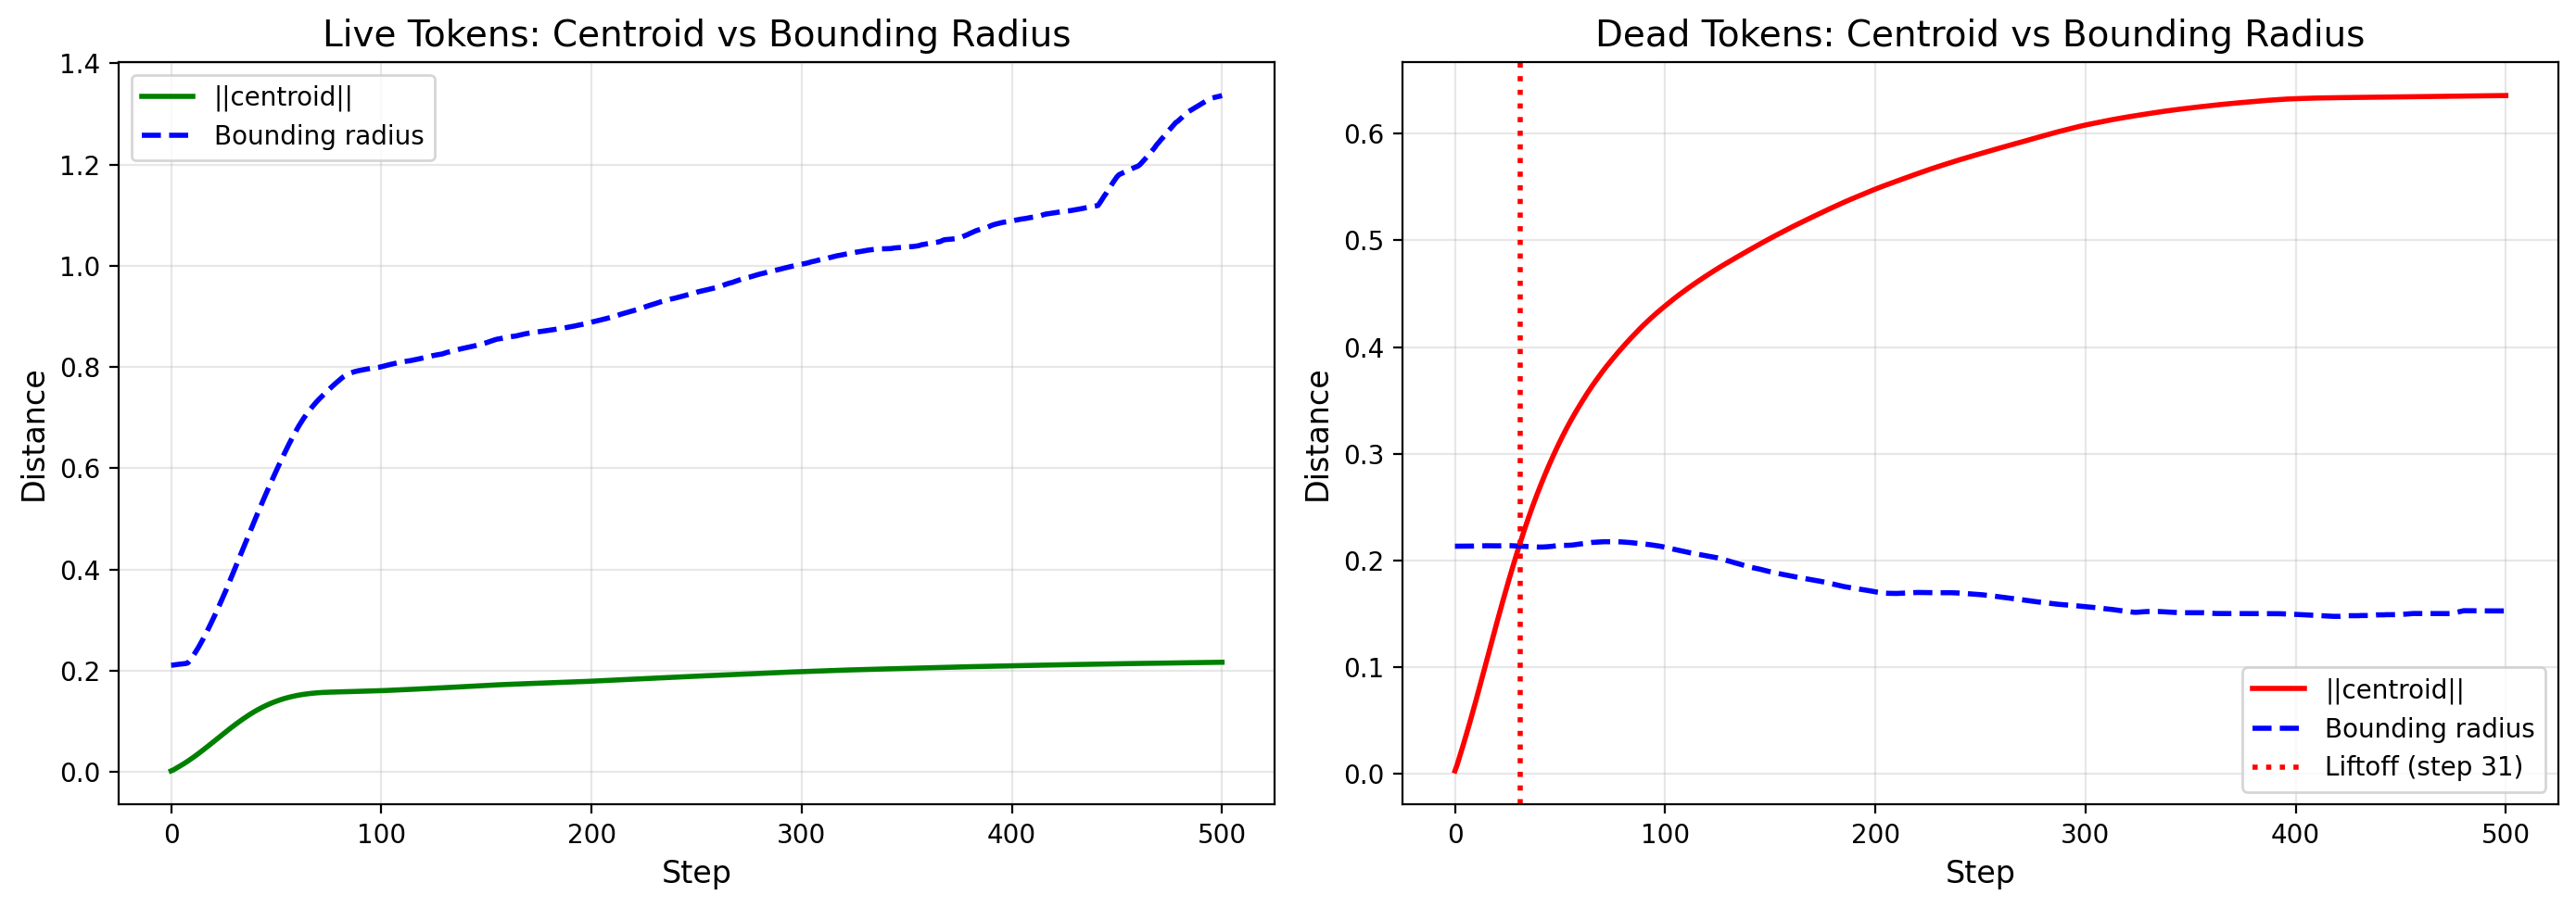

In [90]:
# Plot: centroid distance vs bounding radius
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Live tokens
ax = axes[0]
ax.plot(range(len(dist_to_origin_live)), dist_to_origin_live.detach().numpy(), 
        color='green', linewidth=2, label='||centroid||')
ax.plot(range(len(radius_live)), radius_live.detach().numpy(), 
        color='blue', linewidth=2, linestyle='--', label='Bounding radius')
if liftoff_live is not None:
    ax.axvline(liftoff_live, color='red', linestyle=':', linewidth=2, label=f'Liftoff (step {liftoff_live})')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
ax.set_title('Live Tokens: Centroid vs Bounding Radius', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Dead tokens
ax = axes[1]
ax.plot(range(len(dist_to_origin_dead)), dist_to_origin_dead.detach().numpy(), 
        color='red', linewidth=2, label='||centroid||')
ax.plot(range(len(radius_dead)), radius_dead.detach().numpy(), 
        color='blue', linewidth=2, linestyle='--', label='Bounding radius')
if liftoff_dead is not None:
    ax.axvline(liftoff_dead, color='red', linestyle=':', linewidth=2, label=f'Liftoff (step {liftoff_dead})')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
ax.set_title('Dead Tokens: Centroid vs Bounding Radius', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 3. Separation Dynamics

How does the distance between live and dead centroids evolve?

In [91]:
# Live/Dead centroid separation
separation = torch.norm(centroid_live - centroid_dead, dim=1)  # (501,)

print(f"Live/Dead separation:")
print(f"  At t=0: {separation[0].item():.6f}")
print(f"  At t=500: {separation[-1].item():.6f}")
print(f"  Ratio: {separation[-1].item() / separation[0].item():.1f}x")

Live/Dead separation:
  At t=0: 0.003631
  At t=500: 0.431527
  Ratio: 118.8x


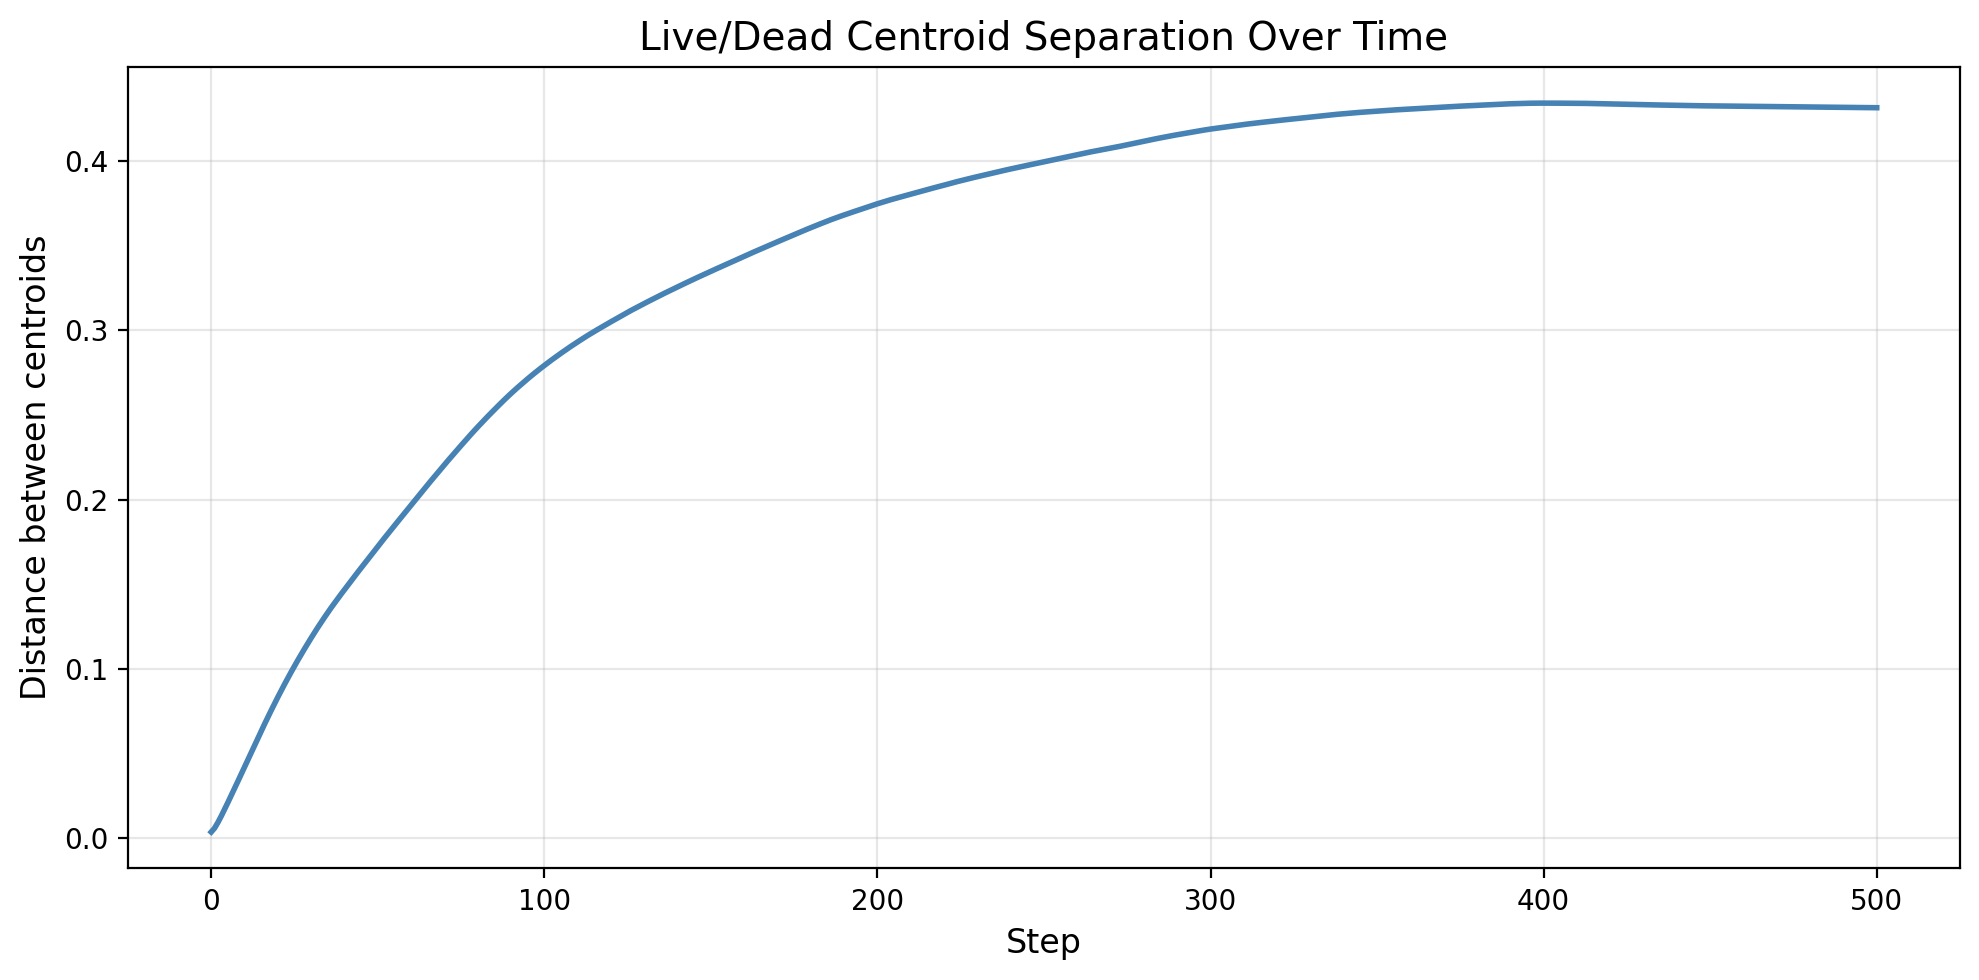

In [92]:
# Plot separation over time
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(len(separation)), separation.detach().numpy(), color=STEELBLUE, linewidth=2)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Distance between centroids', fontsize=12)
ax.set_title('Live/Dead Centroid Separation Over Time', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Summary Statistics

In [93]:
print("=" * 70)
print("CRUCIBLE 3 ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n--- h_mean Autocorrelation ---")
print(f"  Mean over 500 steps: {h_autocorr.mean().item():.4f}")
print(f"  Std: {h_autocorr.std().item():.4f}")
print(f"  Range: [{h_autocorr.min().item():.4f}, {h_autocorr.max().item():.4f}]")

print(f"\n--- Liftoff (origin exits bounding sphere) ---")
if liftoff_live is not None:
    print(f"  Live tokens: step {liftoff_live}")
else:
    print(f"  Live tokens: NEVER (origin still inside at t=500)")
    
if liftoff_dead is not None:
    print(f"  Dead tokens: step {liftoff_dead}")
else:
    print(f"  Dead tokens: NEVER (origin still inside at t=500)")

print(f"\n--- Centroid Displacement ---")
print(f"  Live: {torch.norm(centroid_live[-1] - centroid_live[0]).item():.4f}")
print(f"  Dead: {torch.norm(centroid_dead[-1] - centroid_dead[0]).item():.4f}")
print(f"  Ratio (dead/live): {(torch.norm(centroid_dead[-1] - centroid_dead[0]) / torch.norm(centroid_live[-1] - centroid_live[0])).item():.2f}x")

print(f"\n--- Separation ---")
print(f"  Initial: {separation[0].item():.4f}")
print(f"  Final: {separation[-1].item():.4f}")
print(f"  Increase: {separation[-1].item() / separation[0].item():.1f}x")

print("\n" + "=" * 70)

CRUCIBLE 3 ANALYSIS SUMMARY

--- h_mean Autocorrelation ---
  Mean over 500 steps: 0.9976
  Std: 0.0166
  Range: [0.6318, 1.0000]

--- Liftoff (origin exits bounding sphere) ---
  Live tokens: NEVER (origin still inside at t=500)
  Dead tokens: step 31

--- Centroid Displacement ---
  Live: 0.2165
  Dead: 0.6355
  Ratio (dead/live): 2.94x

--- Separation ---
  Initial: 0.0036
  Final: 0.4315
  Increase: 118.8x

